# Продуктовая аналитика: Методы сегментации клиентов и целевой аудитории

Обсудим, зачем необходимо сегментировать целевую аудиторию. Поговорим об особенностях сегментации в B2B и B2C продуктах. Познакомимся с популярными критериями выделения сегментов и методами сегментации: описательными (модель 5W, Khramatrix и др.) и аналитическими (RFM, когорты, k-means и др.).

# Проект. RFM анализ

**Скачайте датасет и проведите RFM анализ. В каждом подсегменте поделите пользователей на 4 класса. Отсчитывайте количество дней, прошедших с момента последней покупки, с максимальной даты покупки в датасете.**

- Какое максимальное кол-во покупок было совершено одним пользователем?
- Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)
- Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?
- Какая верхняя граница у количества покупок у пользователей с классом 2 в подсегменте R?
- Сколько пользователей попало в сегмент 111?
- Сколько пользователей попало в сегмент 311?
- В каком RFM-сегменте самое большое кол-во пользователей?
- В каком RFM-сегменте самое маленькое кол-во пользователей?
- Какое количество пользователей попало в самый малочисленный сегмент?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
project = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/product_analytics/RFM_ht_data.csv', sep = ',')

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
project.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [4]:
project.shape

(332730, 4)

Приводим данные в нужный формат:

In [5]:
project['InvoiceDate']=pd.to_datetime(project['InvoiceDate'])
project['CustomerCode']=project['CustomerCode'].astype(str)
project['InvoiceNo']=project['InvoiceNo'].astype(str)

In [6]:
last_date=project['InvoiceDate'].max()

In [7]:
project.groupby('CustomerCode', as_index=False).size().sort_values('size', ascending=False)

,CustomerCode,size
89388,19057820,204
44594,13215452,113
10347,13032521,106
97077,19080880,99
119951,99003061,90
...,...,...
58910,13272861,1
58911,13272871,1
58913,13272875,1
58914,13272878,1


In [8]:
# Создаём RFM-таблицу

rfm_table=project.groupby('CustomerCode',as_index=False).agg({'InvoiceDate':lambda x: (last_date-x.max()).days,
                                         'InvoiceNo':lambda x:len(x),
                                         'Amount':lambda x:x.sum()})


rfm_table['InvoiceDate'] = rfm_table['InvoiceDate'].astype(int)


rfm_table=rfm_table.rename(columns={'InvoiceDate':'recency',
                         'InvoiceNo':'frequency',
                         'Amount':'monetary_value'})

rfm_table

,CustomerCode,recency,frequency,monetary_value
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88
...,...,...,...,...
123728,99099927,10,1,961.10
123729,99099936,0,1,1521.78
123730,99099959,8,2,1444.56
123731,99099963,19,1,3018.91


In [9]:
# Рассчитаем квантили

quantiles=rfm_table.quantile(q=(0.25,0.5,0.75))
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [10]:
# Разобьём пользователей на классы

def Rclass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.5]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]:
        return 3
    else:
        return 4
    
def FMclass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.5]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]:
        return 2
    else:
        return 1

In [11]:
rfm_segmentation=rfm_table

In [12]:
rfm_segmentation['R_quantile']=rfm_segmentation['recency'].apply(Rclass,args=('recency', quantiles))
rfm_segmentation['F_quantile']=rfm_segmentation['frequency'].apply(FMclass,args=('frequency', quantiles))
rfm_segmentation['M_quantile']=rfm_segmentation['monetary_value'].apply(FMclass,args=('monetary_value', quantiles))
rfm_segmentation['RFM_class']=rfm_segmentation['R_quantile'].map(str)\
                             +rfm_segmentation['F_quantile'].map(str)\
                             +rfm_segmentation['M_quantile'].map(str)

In [13]:
rfm_segmentation.head()

,CustomerCode,recency,frequency,monetary_value,R_quantile,F_quantile,M_quantile,RFM_class
0,02213019,19,1,1609.20,4,4,3,443
1,02213042,22,3,9685.48,4,2,1,421
2,02213071,29,1,415.00,4,4,4,444
3,02213088,23,1,305.00,4,4,4,444
4,02213092,25,1,1412.88,4,4,3,443


Какое максимальное кол-во покупок было совершено одним пользователем?

In [14]:
rfm_segmentation.frequency.max()

204

Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)

In [15]:
rfm_segmentation.query('M_quantile == 4').monetary_value.max()

765.0

Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?

In [16]:
rfm_segmentation.query('F_quantile == 1').frequency.min()

4

Какое максимальное количество дней может пройти с момента последней покупки для того, чтобы пользователь попал в класс 2 в подсегменте R?

In [17]:
rfm_segmentation.query('R_quantile == 2').recency.max()

8

Сколько пользователей попало в сегмент 111?

In [18]:
rfm_segmentation.query('RFM_class == "111"').shape[0]

9705

Сколько пользователей попало в сегмент 311?

In [19]:
rfm_segmentation.query('RFM_class == "311"').shape[0]

1609

В каком RFM-сегменте самое большое кол-во пользователей?

In [20]:
rfm_segmentation.groupby('RFM_class').size().idxmax()

'444'

В каком RFM-сегменте самое маленькое кол-во пользователей?

In [21]:
rfm_segmentation.groupby('RFM_class').size().idxmin()

'414'

Какое количество пользователей попало в самый малочисленный сегмент?

In [22]:
rfm_segmentation.groupby('RFM_class').size().min()

2

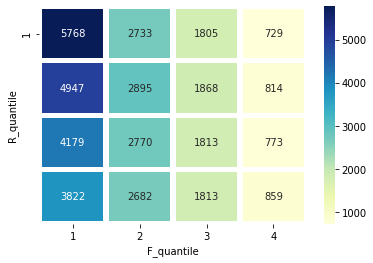

In [23]:
# heatmap

rfm_viz = rfm_segmentation.pivot_table(
                        index='R_quantile', 
                        columns='F_quantile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_viz, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);